## Machine Learning Univariate Analysis for Temperature Forecast

In [1]:
%matplotlib inline

# import required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

sns.set()

DATA_PATH = "..\\data\\"

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [3]:
# read 'SF.csv'  dataset as a dataframe
SF = pd.read_csv(DATA_PATH + 'SF.csv', low_memory =  False)

# Convert index column to datetime dtype.
SF.datetime = pd.to_datetime(SF.datetime, infer_datetime_format = True)
SF.set_index('datetime', inplace = True)

# Only keep temperature attribute. drop rest of the columns.
SF_Temp = SF.drop(['Pressure', 'Humidity', 'Wind Speed'], axis = 1)

# Subtracting the seasonal component from the Temperature series
#result = seasonal_decompose(SF_Temp.Temperature, model='additive')
#SF_Temp.Temperature = SF_Temp.Temperature - result.seasonal

print(SF.shape)
print(SF.info(verbose = True, null_counts = True))

(44460, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44460 entries, 2012-10-01 13:00:00 to 2017-10-28 00:00:00
Data columns (total 5 columns):
Temperature       44460 non-null float64
Pressure          44460 non-null float64
Humidity          44460 non-null float64
Wind Speed        44460 non-null float64
Wind Direction    44460 non-null float64
dtypes: float64(5)
memory usage: 2.0 MB
None


In [4]:
# read 'weather_temp_all.csv'  dataset as a dataframe
df_temp_all = pd.read_csv(DATA_PATH + 'weather_temperature.csv', low_memory =  False)
# Convert index column to datetime dtype.
df_temp_all.datetime = pd.to_datetime(df_temp_all.datetime, infer_datetime_format = True)
df_temp_all.set_index('datetime', inplace = True)

Features = df_temp_all.columns
print(Features)

print(df_temp_all.shape)
print(df_temp_all.info(verbose = True, null_counts = True))

# All data needs to be scaled to a small range like 0 to 1 for the neural
# network to work well. Create scalers for the inputs and outputs.
df_temp_all_vals = df_temp_all.values
df_temp_all_Scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(df_temp_all_vals)
print(df_temp_all_Scaled.shape)

Index(['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles',
       'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver',
       'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis',
       'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta',
       'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh',
       'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston',
       'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya',
       'Jerusalem'],
      dtype='object')
(44460, 36)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44460 entries, 2012-10-01 13:00:00 to 2017-10-28 00:00:00
Data columns (total 36 columns):
Vancouver            44460 non-null float64
Portland             44460 non-null float64
San Francisco        44460 non-null float64
Seattle              44460 non-null float64
Los Angeles          44460 non-null float64
San Diego            44460 non-null float64
Las Vegas            44460 non-null f

In [5]:
# initialize a list to store test results
test_ar = []

In [6]:
# Accuracy metrics
def accuracy_metrics(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.sqrt(np.mean((forecast - actual)**2))  # RMSE
    print('Mean Absolute Percent Error ', mape, 'Mean Absolute Error', mae, 'Root Mean Square Error (rmse) ' , rmse)
    return mape, mae, rmse

### Naive Model - San Francisco Temperature

In [7]:
lags_size = 2 # 2 hrs
num_samples = SF_Temp.shape[0] - lags_size
y_test = np.empty((num_samples, 1))
y_pred = np.empty((num_samples, 1))
for i in range(lags_size, num_samples):
    y_test[i] = SF_Temp.Temperature[i]
    y_pred[i] = (SF_Temp.Temperature[i-1] + SF_Temp.Temperature[i-2])/2
mape, mae, rmse = accuracy_metrics(y_pred, y_test)
test_ar.append({'label':'Naive Model', 'mape' : mape, 'mae': mae,'rmse':rmse})

Mean Absolute Percent Error  0.03496868979450703 Mean Absolute Error 2.109095136095268 Root Mean Square Error (rmse)  2.8702669213081586


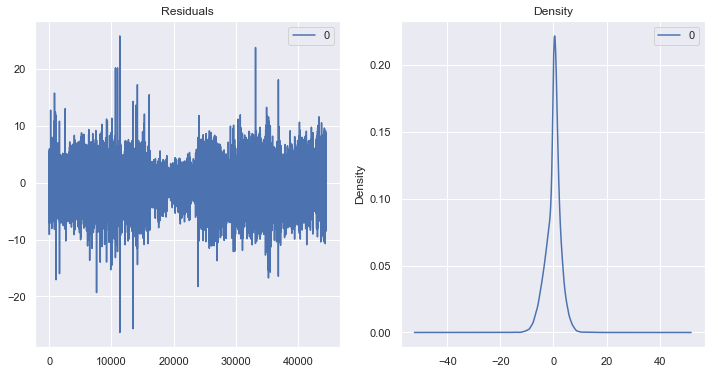

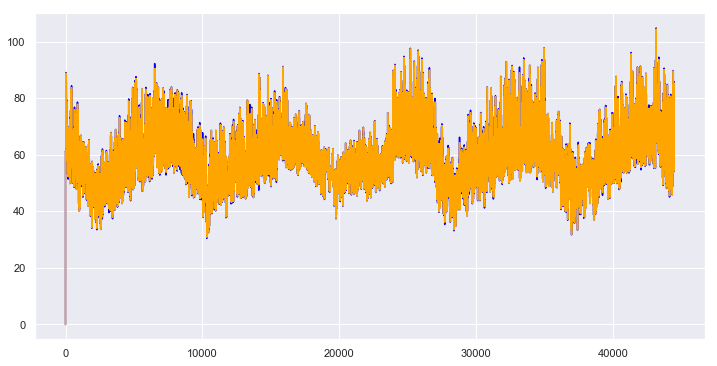

In [8]:
# Plot residual errors
plt.rcParams["figure.figsize"] = [12,6]
residuals = pd.DataFrame(y_pred - y_test)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

plt.plot(y_test, color = 'blue')
plt.plot(y_pred, color = 'orange')
plt.show()

### Data Preparation for Machine Learning Algorithms

In [9]:
lags_size = 6 # 6 hrs
city_cnt = df_temp_all_Scaled.shape[1]
num_samples = (df_temp_all_Scaled.shape[0] - lags_size - 1)  * city_cnt
a = np.empty((num_samples, lags_size))
y_new = np.empty((num_samples))

for i in range(num_samples):
    for k in range(lags_size):
        col = (int)(i % city_cnt)
        row = (int)(i / city_cnt)
        a[i][k] = df_temp_all_Scaled[row + k][col]
    y_new[i] = df_temp_all_Scaled[row + lags_size][col]

X_new = pd.DataFrame(a)
print(X_new.shape, y_new.shape)

(1600308, 6) (1600308,)


In [10]:
# Create Training and Test 80/20 ratio
test_size = 36 * 10    #X_new.shape[0] - training_size
training_size = X_new.shape[0] - test_size

x_train = X_new.iloc[:training_size]
x_test = X_new.iloc[training_size:]
y_train = y_new[:training_size]
y_test = y_new[training_size:]
print(x_train.shape, x_test.shape)

(1599948, 6) (360, 6)


### Linear Regression - Temperature All Cities

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model_lr = LinearRegression(fit_intercept = False)
model_lr = model_lr.fit(x_train, y_train)
y_pred_lr = model_lr.predict(x_test)
mape, mae, rmse = accuracy_metrics(y_pred_lr, y_test)
        
test_ar.append({'label':'LinearRegression', 'mape' : mape, 'mae': mae,'rmse':rmse})   

Mean Absolute Percent Error  0.03239204743339057 Mean Absolute Error 0.017378001591768836 Root Mean Square Error (rmse)  0.02659141307972128


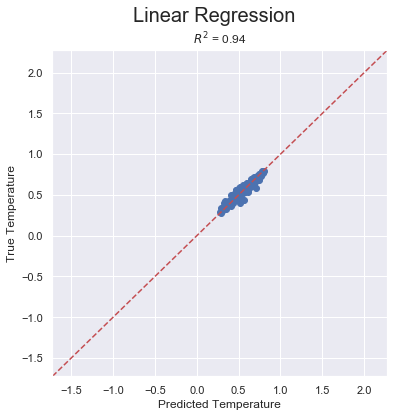

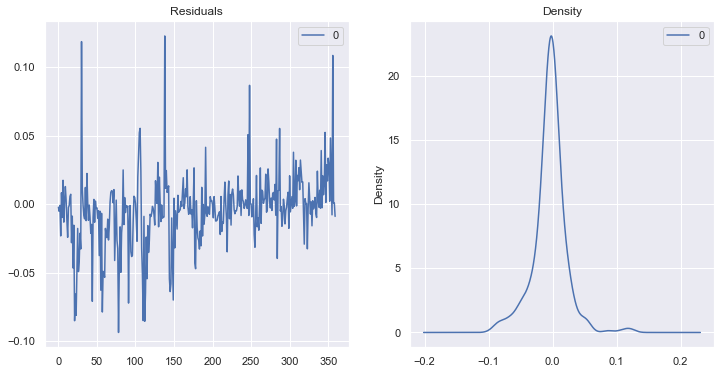

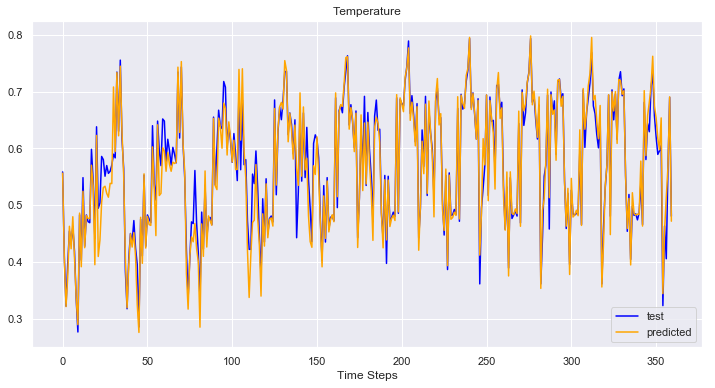

In [12]:
fig, ax = plt.subplots(figsize = (6,6))
plt.suptitle("Linear Regression", fontsize=20)
ax.scatter(y_pred_lr, y_test)
one_to_one = np.arange(y_test.min() - 2, y_test.max() + 2)
ax.plot(one_to_one, one_to_one, c='r', linestyle = '--')

ax.set_xlim((one_to_one[0], one_to_one[-1]))
ax.set_ylim((one_to_one[0], one_to_one[-1]))
ax.set_xlabel('Predicted Temperature')
ax.set_ylabel('True Temperature')
ax.set_title(f'$R^{2}$ = {r2_score(y_test, y_pred_lr):3.2f}')

#print(accuracy_metrics(y_test, y_pred))

# Plot residual errors
plt.rcParams["figure.figsize"] = [12,6]
residuals = pd.DataFrame(y_pred_lr - y_test)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

plt.show()

p1_lr = plt.plot(y_test, color = 'blue')
p2_lr = plt.plot(y_pred_lr, color = 'orange')
plt.title("Temperature")
plt.xlabel("Time Steps")
plt.legend((p1_lr[0], p2_lr[0]),("test", "predicted"))

plt.show()

### Random Forest - Temperature All Cities

In [13]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(random_state=0, n_estimators = 500, max_depth = None, 
                              max_features = lags_size, min_samples_split = 10, min_samples_leaf = 10, bootstrap = False)
model_rf.fit(x_train, y_train)
y_pred_rf = model_rf.predict(x_test)

mape, mae, rmse = accuracy_metrics(y_pred_rf, y_test)
test_ar.append({'label':'RandomForestRegressor', 'mape' : mape, 'mae': mae,'rmse':rmse})   
#print(accuracy_metrics(y_test, y_pred_rf))

Mean Absolute Percent Error  0.0313033762990866 Mean Absolute Error 0.016710343802347382 Root Mean Square Error (rmse)  0.02472150250387669


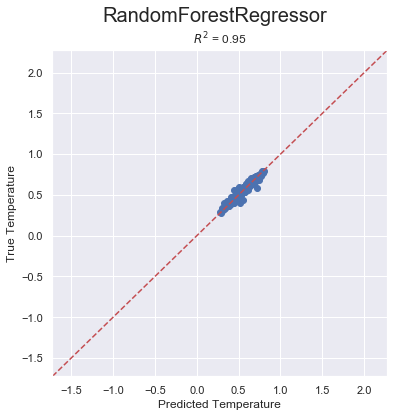

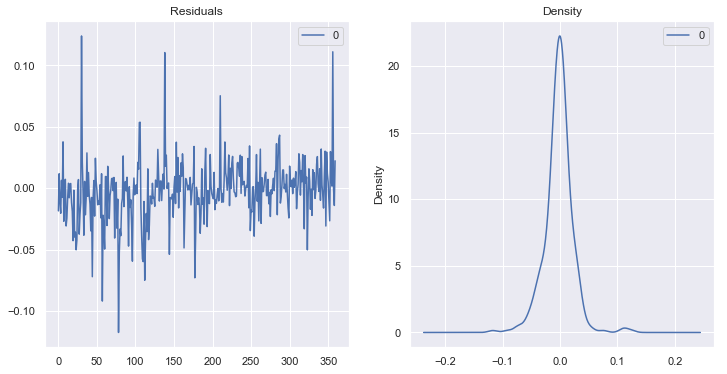

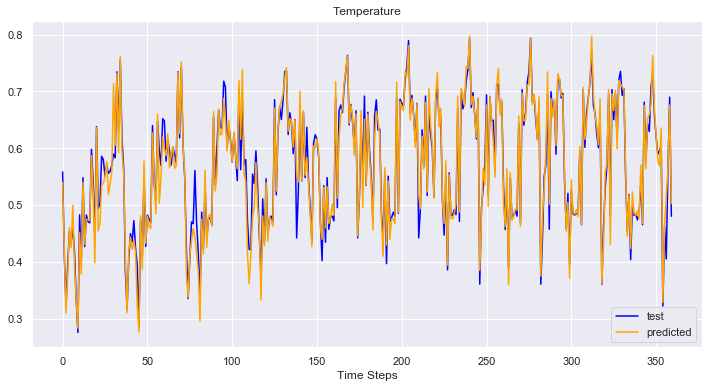

In [14]:
fig, ax = plt.subplots(figsize = (6,6))
plt.suptitle("RandomForestRegressor", fontsize=20)
ax.scatter(y_pred_rf, y_test)
one_to_one = np.arange(y_test.min() - 2, y_test.max() + 2)
ax.plot(one_to_one, one_to_one, c='r', linestyle = '--')

ax.set_xlim((one_to_one[0], one_to_one[-1]))
ax.set_ylim((one_to_one[0], one_to_one[-1]))
ax.set_xlabel('Predicted Temperature')
ax.set_ylabel('True Temperature')
ax.set_title(f'$R^{2}$ = {r2_score(y_test, y_pred_rf):3.2f}')

# Plot residual errors
plt.rcParams["figure.figsize"] = [12,6]
residuals = pd.DataFrame(y_pred_rf - y_test)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

p1_rf = plt.plot(y_test, color = 'blue')
p2_rf = plt.plot(y_pred_rf, color = 'orange')
plt.title("Temperature")
plt.xlabel("Time Steps")
plt.legend((p1_rf[0], p2_rf[0]),("test", "predicted"))

plt.show()

### XGBoost - Temperature All Cities

In [15]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor() #random_state=0, n_estimators = 500, max_depth = None, 
                       #       max_features = 20, min_samples_split = 10, min_samples_leaf = 10, bootstrap = False)
model_xgb.fit(x_train, y_train)
y_pred_xgb = model_xgb.predict(x_test)

mape, mae, rmse = accuracy_metrics(y_pred_xgb, y_test)
test_ar.append({'label':'XGBRegressor', 'mape' : mape, 'mae': mae,'rmse':rmse})   
#print(accuracy_metrics(y_test, y_pred_xgb))

Mean Absolute Percent Error  0.03222597952498729 Mean Absolute Error 0.01732185860757921 Root Mean Square Error (rmse)  0.026547649587452125


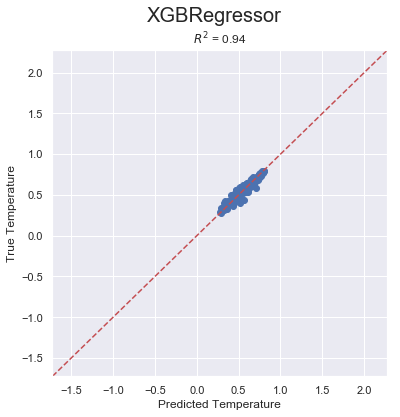

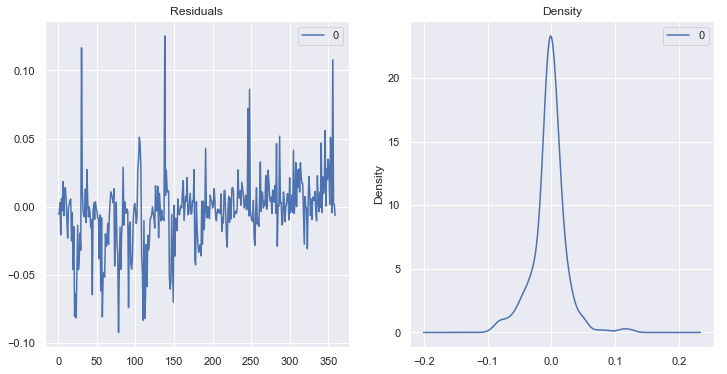

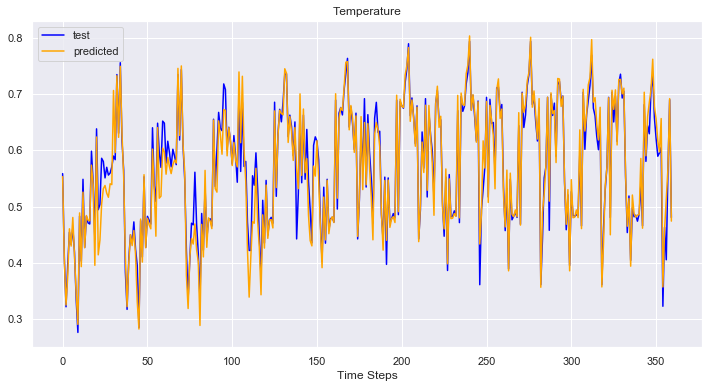

In [17]:
# Plot residual errors
fig, ax = plt.subplots(figsize = (6,6))
plt.suptitle("XGBRegressor", fontsize=20)
ax.scatter(y_pred_xgb, y_test)
one_to_one = np.arange(y_test.min() - 2, y_test.max() + 2)
ax.plot(one_to_one, one_to_one, c='r', linestyle = '--')

ax.set_xlim((one_to_one[0], one_to_one[-1]))
ax.set_ylim((one_to_one[0], one_to_one[-1]))
ax.set_xlabel('Predicted Temperature')
ax.set_ylabel('True Temperature')
ax.set_title(f'$R^{2}$ = {r2_score(y_test, y_pred_xgb):3.2f}')

plt.rcParams["figure.figsize"] = [12,6]
residuals = pd.DataFrame(y_pred_xgb - y_test)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

p1_xgb = plt.plot(y_test, color = 'blue')
p2_xgb = plt.plot(y_pred_xgb, color = 'orange')
plt.title("Temperature")
plt.xlabel("Time Steps")
plt.legend((p1_xgb[0], p2_xgb[0]),("test", "predicted"))
plt.show()

#### Print Test results

In [ ]:
print(test_ar)